## Data Manipulation
### Imports 

In [31]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

date_cols = [2, 19, 20, 26]
injuries = pd.read_csv('data/injuries.csv', parse_dates=date_cols)

### Manipulation

In [8]:
injuries_df = injuries.copy() 
injuries_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6541 entries, 0 to 6540
Data columns (total 29 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   PlayerName                  6541 non-null   object        
 1   PlayerId                    6540 non-null   object        
 2   PlayerDOB                   6540 non-null   datetime64[ns]
 3   Height                      6540 non-null   float64       
 4   Weight                      6540 non-null   float64       
 5   Positions                   6540 non-null   object        
 6   GroupPosition               6540 non-null   object        
 7   DraftPick                   5865 non-null   float64       
 8   IsActive                    6540 non-null   object        
 9   FirstSeason                 6541 non-null   int64         
 10  LastSeason                  6541 non-null   int64         
 11  SeasonsPlayed               6541 non-null   int64       

## Adding Cols

In [9]:
start_day = '-10-20' 
injuries_df['approx_first_day'] = pd.to_datetime((injuries_df['FirstSeason'].astype(str) + start_day), format='%Y-%m-%d')

end_day = '-04-15'
injuries_df['approx_last_day'] = pd.to_datetime((injuries_df['LastSeason'].astype(str) + end_day), format='%Y-%m-%d')

remaining_days = injuries_df['approx_last_day'] - injuries_df['DateInjured']
injuries_df['remaining_days'] = (remaining_days / pd.Timedelta(1, 'D')).astype(int)

injuries_df['log_days_injured'] = np.log(injuries_df['DaysInjured'])

## Missing Values 


In [75]:
null_counts = injuries_df.isnull().sum()
null_counts[null_counts > 0].sort_values(ascending=False)

DraftPick                     676
TeamNameFull                  202
TeamLocation                  202
SeasonEndYear                 202
TeamMadePlayoffs              202
GamesMissed                    92
DaysBetweenGames               92
LastTransactionDate             2
LastTransactionDescription      2
LastTransactionType             2
dtype: int64

In [ ]:
This one row has a lot of missing data so I am going to remove it.

In [71]:
injuries_df[injuries_df['PlayerId'].isnull()]


,PlayerName,PlayerId,PlayerDOB,Height,Weight,Positions,GroupPosition,DraftPick,IsActive,FirstSeason,...,DaysBetweenGames,BodyPartInjured,InjuryDescription,LastTransactionDate,LastTransactionDescription,LastTransactionType,approx_first_day,approx_last_day,remaining_days,log_days_injured
BodyPartInjured,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,unknown,NaN,NaT,NaN,NaN,NaT,NaT,NaN,NaN


In [72]:
injuries_df = injuries_df.dropna(subset='PlayerId')

Body part injured and draft pick are largest null. The distribution of the target variable for body part injured does seem to be slightly different for null vs not null while for draft pick the difference does not seem too significant. 

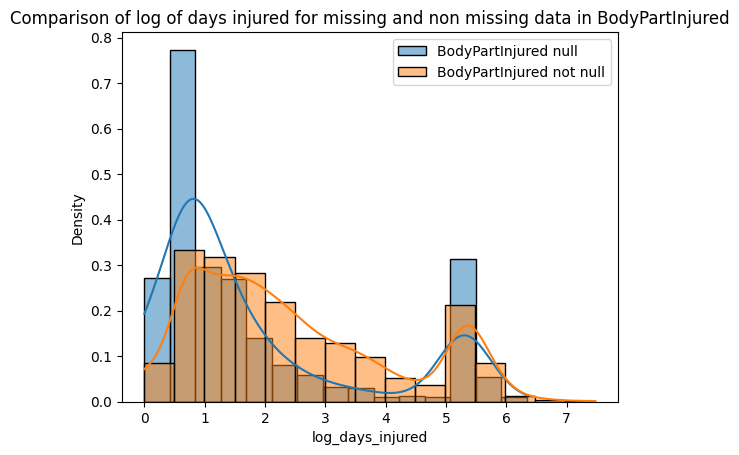

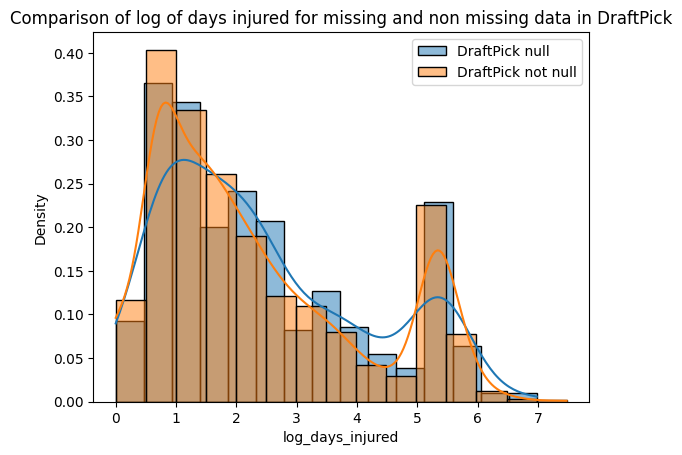

In [57]:
def compare_null(col):
    is_missing = injuries_df[col].isnull()
    sns.histplot(injuries_df[is_missing]['log_days_injured'], stat='density', bins=15, kde=True, label=col + ' null')
    sns.histplot(injuries_df[~is_missing]['log_days_injured'], stat='density', bins=15, kde=True, label=col + ' not null')
    plt.legend()
    plt.title('Comparison of log of days injured for missing and non missing data in ' + col)
    plt.show()


compare_null('BodyPartInjured')
compare_null('DraftPick')


I am filling the body part with 'unknown' since this column contains important information.

In [74]:
injuries_df.loc[:, 'BodyPartInjured'] = injuries_df['BodyPartInjured'].fillna('unknown')

### Export

In [76]:
injuries_df.to_csv('data/injuries_cleaned.csv', index=False)